In [200]:
## Pyro GP tutorial used as starting point:
## https://pyro.ai/examples/gp.html

import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as pdist
import arviz

# Partition observations
X = np.asarray([x / 29 for x in range(1, 31)])
np.random.shuffle(X)
Y = 6 * np.square(X) - np.square(np.sin(6 * np.pi * X)) - 5 * np.power(X, 4) + 3 / 2 + np.random.normal(0.0, 0.01, 30)
Xtrain, Xtest, Ytrain, Ytest = torch.tensor(X[10:]), torch.tensor(X[:10]), torch.tensor(Y[10:]), torch.tensor(Y[:10])

### Selecting a suitable model

In [201]:
# We chose a GP regression model and the Matern 3/2 kernel. In this setup, we have three hyper-parameters.
# I) The variance of the kernel, II) the lengthscale of the kernel, and III) the gaussian noise of the model.
# We chose to let the gaussian noise be fixed and equal to the noise of our data, while keeping the variance
# and lengthscale of the kernel variable. The prior distrubition we chose is a multivariate normal
# distribution (i.e. we consider the variance and lengthscale as normally distributed), with mean and variance
# based on what seems reasonable for the Matern 3/2 kernel, based on the lecture slides.

# Define model
class MyGPModel():
    def __init__(self, kernel):
        self.kernel = kernel
        
    def __call__(self, xs, ys=None):
        self.kernel.lengthscale = pyro.sample("lengthscale", pdist.LogNormal(0.0, 1.0))
        self.kernel.variance = pyro.sample("variance", pdist.LogNormal(0.0, 1.0))
        self.gp_model =  gp.models.GPRegression(xs, ys, self.kernel, noise=torch.tensor(0.01))
        return self.gp_model.model()

# Define kernel
def kernel(theta):
    return gp.kernels.Matern32(input_dim=1, variance=theta[0], lengthscale=theta[1])

# Define model
def model(xs, ys, kernel):
    return gp.models.GPRegression(xs, ys, kernel, noise=torch.tensor(0.01))

# Computes log-likelihood
def logLikelihood(xs, ys, kernel, theta):
    # See derivation in report
    t1 = 0.5 * torch.transpose(ys, 0, 0) * torch.linalg.inv(kernel.forward(xs)) * ys
    t2 = 0.5 * torch.log(torch.linalg.det(kernel.forward(xs)))
    t3 = 15.0 * torch.log(2 * torch.tensor(np.pi))
    return (- t1 - t2 - t3) * prior.log_prob(theta)

# Pick prior distributions
pyro.clear_param_store()
some_theta = [torch.tensor(1.5),torch.tensor(1)]
k = kernel(some_theta)
gpr = model(Xtrain, Ytrain, k)
gpr.kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))

### Compute posterior predictive

In [202]:
optimizer = torch.optim.SGD(gpr.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))

variance = 1.195123553276062
lengthscale = 0.7409237623214722
noise = 0.14042101800441742


### Using NUTS

In [203]:
# Model is GP model from pyro
W = 50 # Number of warmup steps
C = 1 # Number of chains
S = 500 # Number of samples used in prediction
pyro.clear_param_store()
gp_kernel = kernel(some_theta)
# gp_model_nuts = model(Xtrain, Ytrain)
# guide = pyro.infer.autoguide.AutoDelta(model)

gp_model = MyGPModel(gp_kernel)
nuts_kernel = pyro.infer.NUTS(gp_model, jit_compile=False)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=S, num_chains=C, warmup_steps=W)
mcmc.run(Xtrain, Ytrain)

Sample: 100%|██████████| 600/600 [09:36,  1.04it/s, step size=7.94e-03, acc. prob=0.423]


#### Checking quality of samples using arviz

/Users/vic/Desktop/Computer Science/2/PML/Final Project/PMLFinalProject/venv/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


<xarray.Dataset>
Dimensions:  (y_dim_0: 20)
Coordinates:
  * y_dim_0  (y_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    y        (y_dim_0) float64 0.6906 1.995 0.5775 2.491 ... 1.688 1.15 1.976
Attributes:
    created_at:                 2024-01-18T21:42:55.175785
    arviz_version:              0.17.0
    inference_library:          pyro
    inference_library_version:  1.8.6
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lengthscale  0.165  0.033   0.116    0.234      0.003    0.002     121.0   
variance     3.249  1.546   1.103    5.711      0.147    0.105     107.0   

             ess_tail  r_hat  
lengthscale     179.0    NaN  
variance        145.0    NaN  


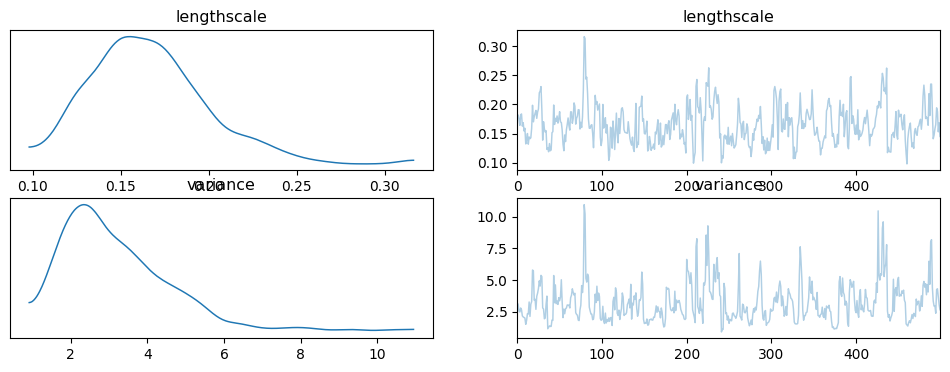

array([<Axes: title={'center': 'lengthscale'}>,
       <Axes: title={'center': 'variance'}>], dtype=object)

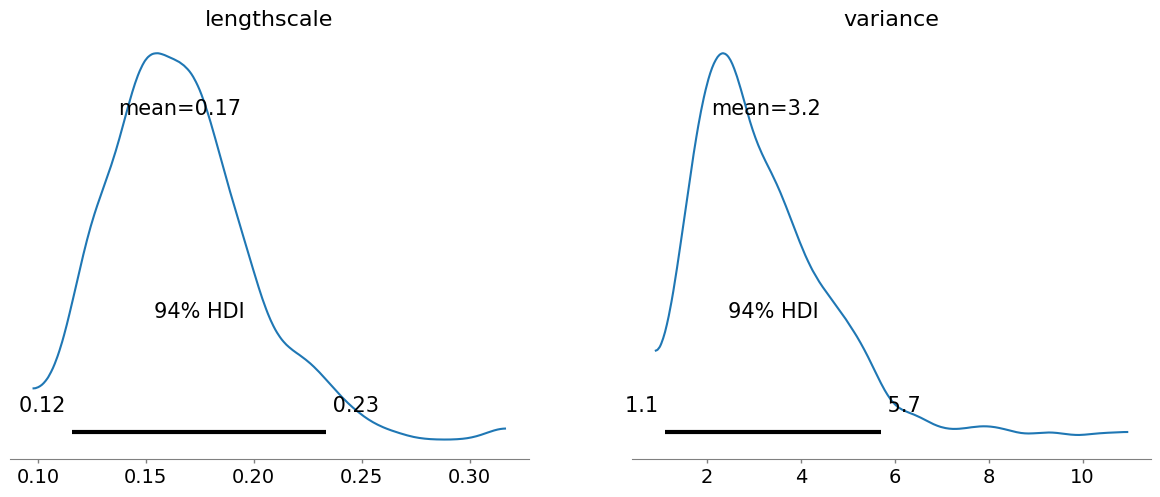

In [204]:
posterior_samples = mcmc.get_samples()
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary)
arviz.plot_trace(data)
plt.show()
arviz.plot_posterior(data)

#### Computing approximate posterior likelihood

In [251]:
def posterior_likelihood(cov_prior, Xtest, Ytest, noise=0.01):
    n = Xtest.shape[0]
    Xtest = Xtest.repeat(2, 1).T
    parenthesis = noise * torch.eye(n) + Xtest @ cov_prior @ Xtest.T
    mean = cov_prior @ Xtest.T @ torch.linalg.inv(parenthesis) @ Ytest
    sigma = cov_prior - cov_prior @ Xtest.T @ torch.linalg.inv(parenthesis) @ Xtest @ cov_prior
    return mean, sigma


def approximate_posterior_likelihood(posterior_samples, Xtest, Ytest, noise=0.01):
    n = posterior_samples.shape[1]
    mean_result = 0
    sigma_result = 0 
    for sample in posterior_samples:
        mean_i, sigma_i = posterior_likelihood(torch.diag(sample), Xtest, Ytest, noise)
        mean_result += mean_i
        sigma_result += sigma_i


    return mean_result / n, sigma_result / n

approximate_posterior_likelihood(torch.vstack([posterior_samples['lengthscale'], posterior_samples['variance']]).T, Xtest, Ytest)

(tensor([ 49.6699, 860.7985], dtype=torch.float64),
 tensor([[ 39.1582, -39.1135],
         [-39.1135,  39.8885]], dtype=torch.float64))